In [1]:
%config InlineBackend.figure_formats = {"retina", "png"}
%matplotlib inline

import os
import glob
import json

import h5py
import matplotlib.pyplot as plt
import matplotlib as mpl
from mpl_toolkits.axes_grid1.anchored_artists import AnchoredSizeBar
import matplotlib.font_manager as fm
import numpy as np
from scipy import io
from shapely import geometry

import tdgl

# figure_dir = None
figure_dir = "../latex/figures"

In [2]:
def loadmat(fname):
    return io.loadmat(fname, simplify_cells=True)

In [3]:
mat = loadmat("../data/measurement/temperature-sweep/T_sweep_05mA_500Hz_FC_series.mat")

temps = mat["T_axis"]
M = mat["M_x"] + 1j * mat["M_y_vec"]
(ix, ) = np.where((temps >= 9) & (temps <= 9.3))
x = M.real[ix]
y = M.imag[ix]
slope, ofs = np.polyfit(x, y, 1)
angle = np.arctan(slope)
M0 = (M * np.exp(-1j * angle))[np.where(temps >= 9.4)].mean()
M_corr = M * np.exp(-1j * angle) - M0
print(f"angle = {angle:.2e} radians, M0 = {M0:.2f} Phi_0 / A")

angle = -9.76e-03 radians, M0 = 5.49-0.39j Phi_0 / A


In [4]:
def get_index(path):
    return int(path.split("/")[-2])

run_name = "9810757"

data_dir = f"../data/simulation/{run_name}"
paths = sorted(glob.glob(os.path.join(data_dir, f"*/results.json")), key=get_index)

In [5]:
with open(paths[0], "r") as f:
    args = json.load(f)["args"]

In [6]:
args

{'I_fc': [0.5, 10.0, 201.0],
 'current_units': 'mA',
 'cycles': 1.5,
 'd': 0.2,
 'directory': '/scratch/groups/kmoler/py-tdgl/results/9810757/0',
 'dt_init': 1e-06,
 'field_units': 'mT',
 'film_points': 4000,
 'film_radius': 15.0,
 'film_shape': 'box',
 'film_smooth': 100,
 'gamma': 1.0,
 'index': 0,
 'lam': 1.35,
 'max_edge_length': 0.5,
 'points_per_cycle': 51.0,
 'save_every': 500,
 'screening': False,
 'seed_solutions': True,
 'slot_radius': 0,
 'slot_size': None,
 'slot_top_center_x': None,
 'slot_top_center_y': None,
 'solve_time': [20000.0, 2000.0],
 'squid_angle': 0,
 'squid_iterations': 5,
 'squid_points': 4000,
 'squid_position': [0.0, 0.0, 0.5],
 'squid_smooth': 100,
 'squid_type': 'hypres-small',
 'xi': 0.9}

In [7]:
num_cycles = args["cycles"]
pts_per_cycle = args["points_per_cycle"]
pts = int(num_cycles * pts_per_cycle)
cycles = np.linspace(0, num_cycles, pts)
phase = np.exp(-1j * 2 * np.pi * cycles)
start, stop, num = args["I_fc"]
I_fcs = np.linspace(start, stop, int(num))

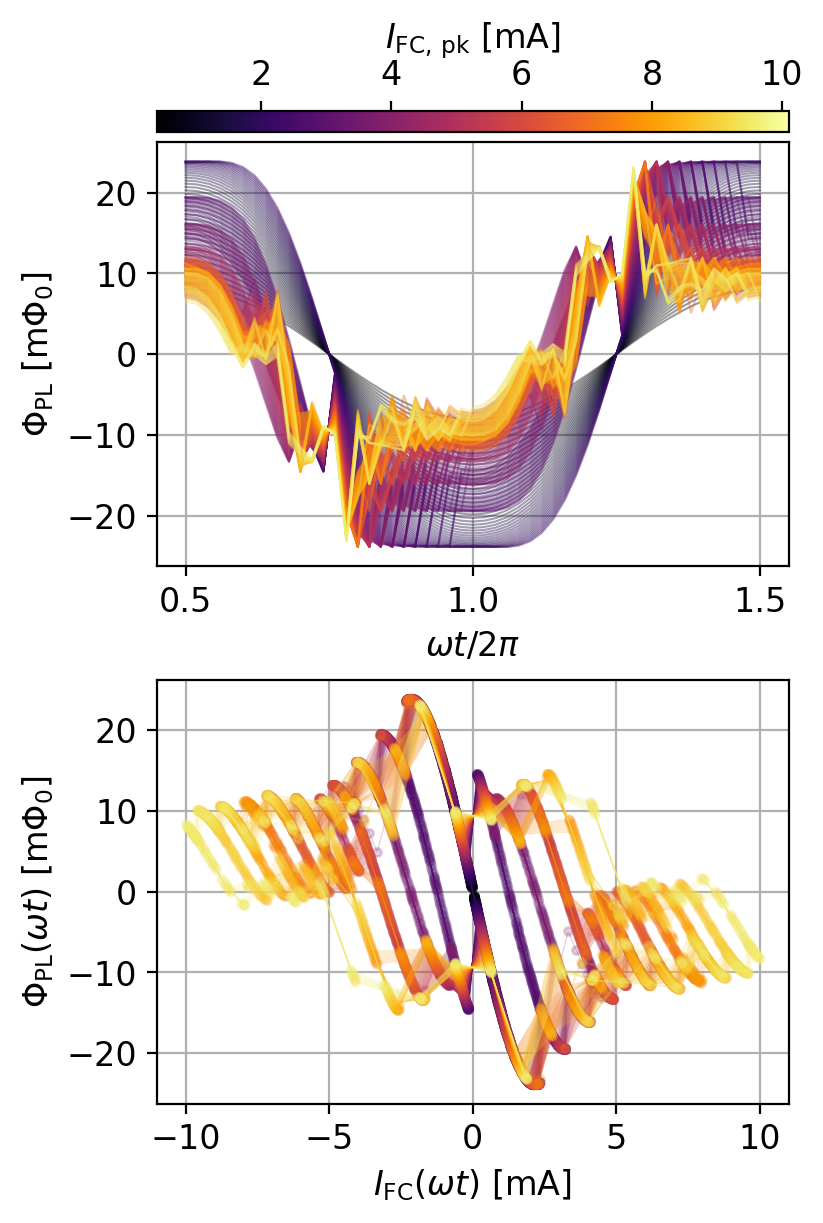

In [8]:
plt.rcParams["font.size"] = 12

fig, (ax, bx) = plt.subplots(2, 1, figsize=(4, 6), constrained_layout=True)
susc = []
all_fluxoids = []
all_fluxes = []
ts = None

cmap = "inferno"

colors = plt.get_cmap(cmap)(np.linspace(0, 1, len(paths) + 10))

ix = slice(int(pts_per_cycle * 0.5), None)
indices = []

for i, path in enumerate(paths):
    with open(path, "r") as f:
        try:
            result = json.load(f)
        except:
            print(path)
            continue
    indices.append(i)
    index = result["args"]["index"]
    I_fc = I_fcs[index]
    current = I_fc * phase.real
    flux = np.array(result["flux"])
    fluxoid = np.array(result["film_fluxoid"])
    all_fluxes.append(flux)
    all_fluxoids.append(fluxoid[ix])
    if ts is None:
        ts = cycles[ix]
    susc.append(np.sqrt(2) * np.trapz(phase[ix] * flux[ix]) / (1e-3 * I_fc) / len(flux[ix]))
    ax.plot(ts, 1e3 * flux[ix], "-", color=colors[i], lw=0.75, alpha=0.4)
    bx.plot(current[ix], 1e3 * flux[ix], ".-", label=str(I_fc), color=colors[i], lw=0.5, alpha=0.2)


susc = np.array(susc)

ax.set_ylabel("$\\Phi_\\mathrm{PL}$ [m$\\Phi_0$]")
ax.grid(True)    
bx.grid(True)
ax.set_xticks([0.5, 1, 1.5])
ax.set_xlabel("$\\omega t/2\\pi$")
bx.set_xlabel("$I_\\mathrm{FC}(\\omega t)$ [mA]")
bx.set_ylabel("$\\Phi_\\mathrm{PL}(\\omega t)$ [m$\\Phi_0$]")

sm = plt.cm.ScalarMappable(cmap=cmap, norm=plt.Normalize(vmin=I_fcs[0] - 0.1, vmax=I_fcs[-1] + 0.1))
cbar = fig.colorbar(sm, ax=[ax, bx], orientation="horizontal", location="top", aspect=30, pad=0.01)
cbar.set_label("$I_{\\mathrm{FC},\\,\\mathrm{pk}}$ [mA]")

In [9]:
path = "../data/measurement/fc-current-sweep"

In [10]:
def get_temp(s):
    return float(s.split(".")[0].split("_")[1].replace("p", "."))

In [11]:
data = {}
for p in sorted(os.listdir(path), key=get_temp):
    data[get_temp(p)] = loadmat(os.path.join(path, p))

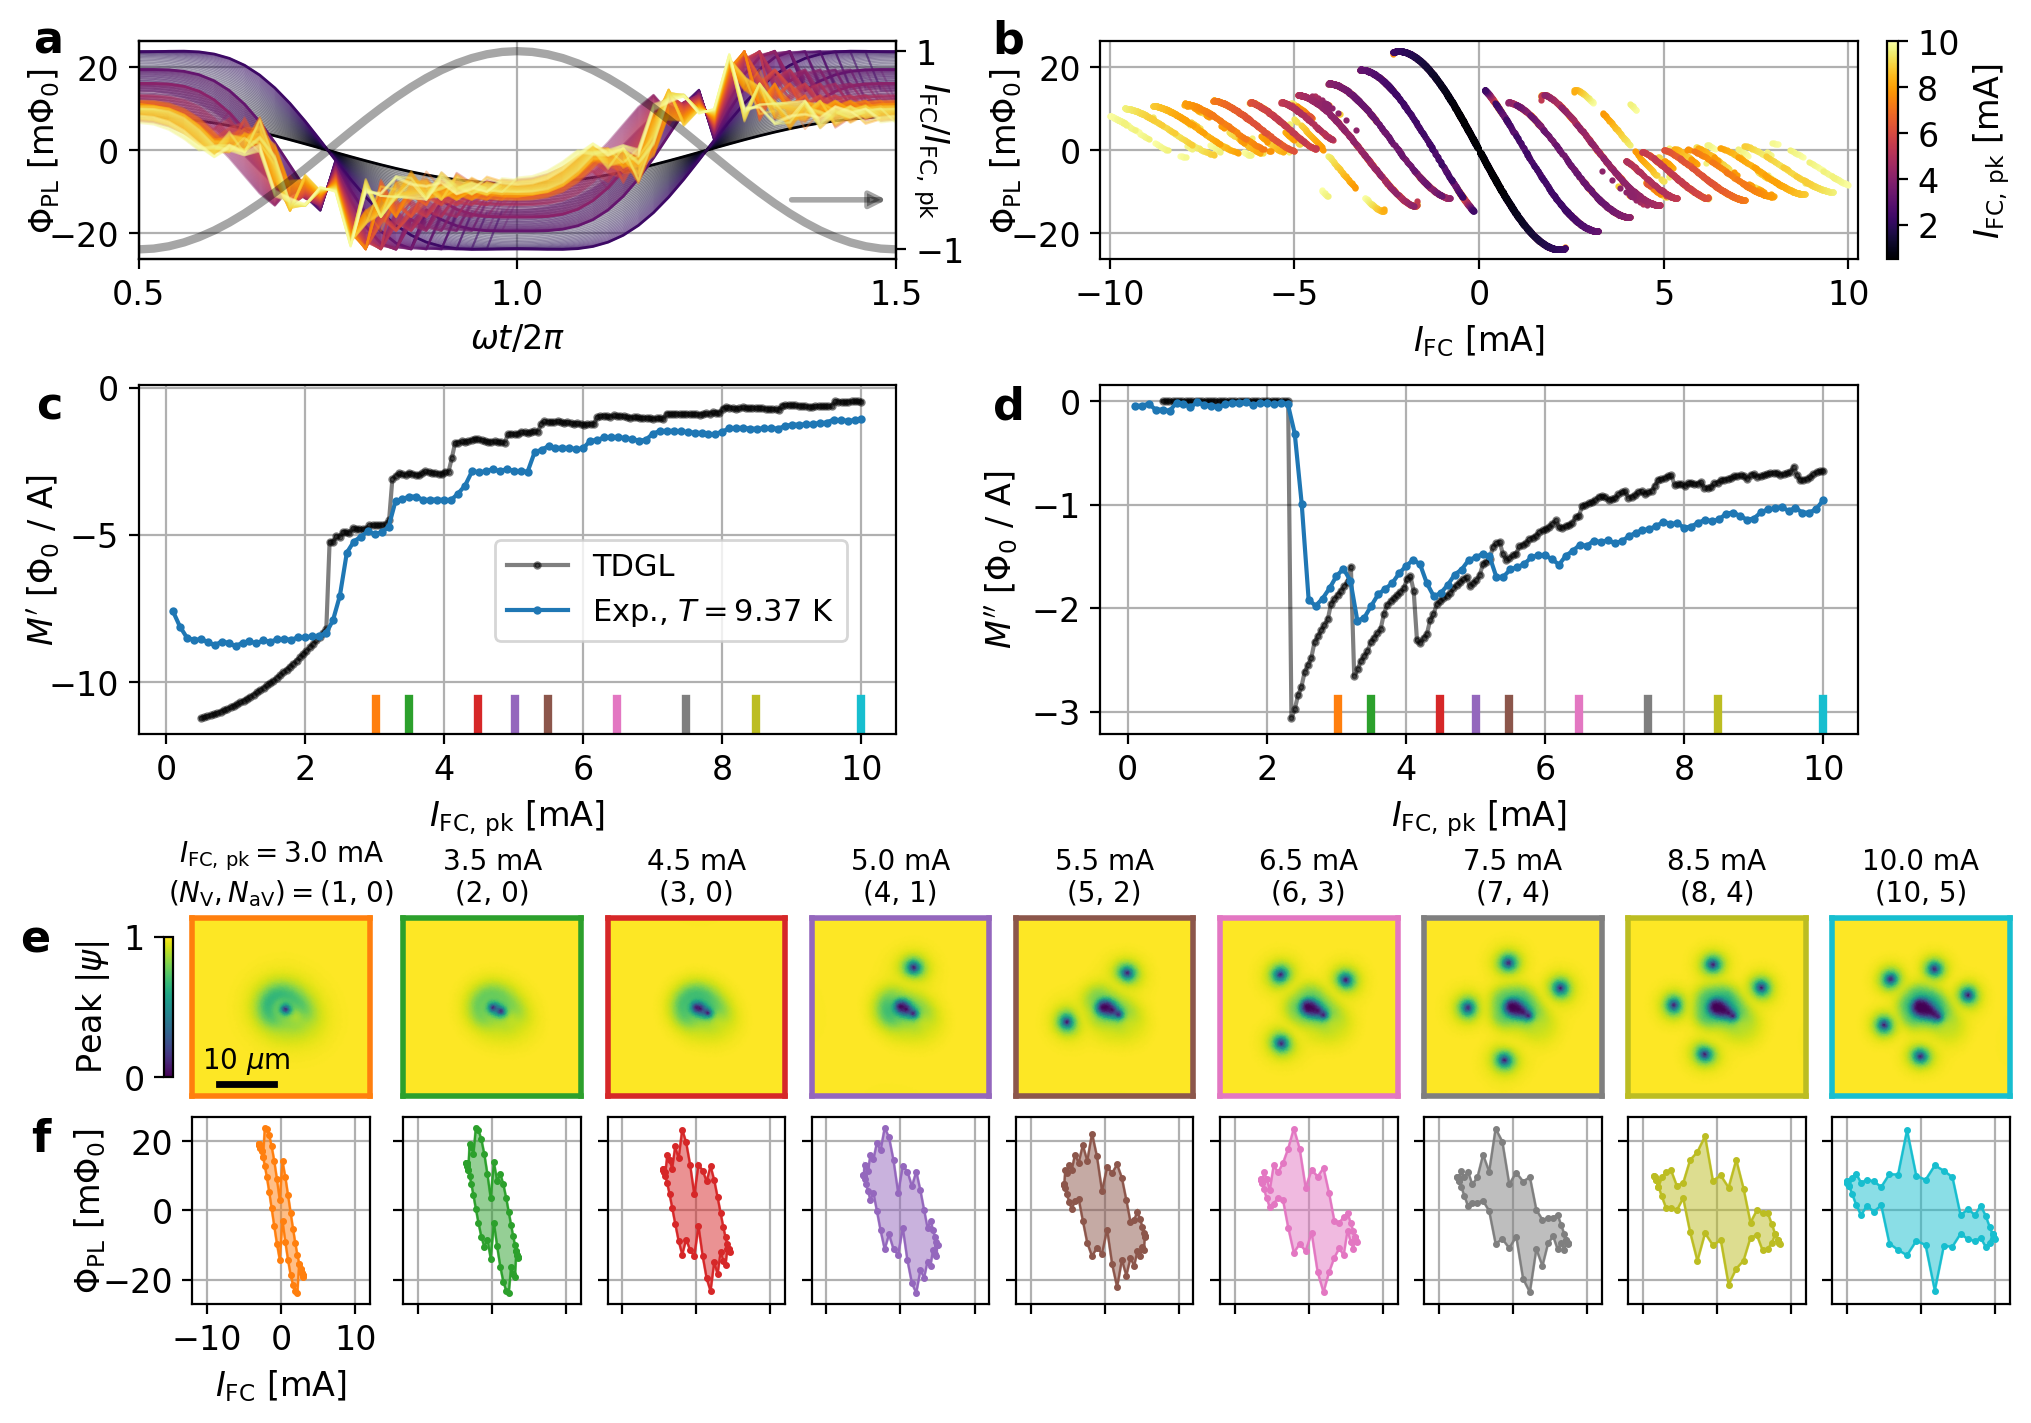

In [12]:
plt.rcParams["font.size"] = 12

fig = plt.figure(figsize=(10, 7), constrained_layout=True)

gs = fig.add_gridspec(3, 2, height_ratios=[1.25, 2, 3.25])
ncols = gs.ncols
ax = fig.add_subplot(gs[0, :ncols//2])
bx = fig.add_subplot(gs[0, ncols//2:])
cx = fig.add_subplot(gs[1, :ncols//2])
dx = fig.add_subplot(gs[1, ncols//2:])

ncols_psi = 9
gs2 = gs[-1, :].subgridspec(2, ncols_psi, height_ratios=[1, 1])
axes = [fig.add_subplot(gs2[0, j]) for j in range(ncols_psi)]
bxes = [fig.add_subplot(gs2[1, j]) for j in range(ncols_psi)]
for a in axes:
    a.set_aspect("equal")
    a.set_xticks([])
    a.set_yticks([])

susc = []
all_fluxoids = []
all_currents = {}
all_fluxes = {}
all_areas = []
ts = None

cmap = "inferno"

colors = plt.get_cmap(cmap)(np.linspace(0, 1, len(paths)))

ix = slice(int(pts_per_cycle * 0.5), None)

highlight_indices = [0, 38, 57, 75]

highlights = []
indices = []

ax2 = ax.twinx()
ax2.set_yticks([-1, 1])
ax2.set_ylabel("$I_\\mathrm{FC}/I_{\\mathrm{FC},\\,\\mathrm{pk}}$", rotation=-90, labelpad=-5)

for i, path in enumerate(paths):
    with open(path, "r") as f:
        try:
            result = json.load(f)
        except:
            print(path)
            continue
    indices.append(i)
    index = result["args"]["index"]
    I_fc = I_fcs[index]
    current = I_fc * phase.real
    all_currents[I_fc] = current
    flux = np.array(result["flux"])
    fluxoid = np.array(result["film_fluxoid"])
    all_fluxes[I_fc] = flux
    all_fluxoids.append(fluxoid[ix])
    if ts is None:
        ts = cycles[ix]
        ax2.plot(ts, phase[ix].real, "k-", lw=3, alpha=0.35)
    susc.append(np.sqrt(2) * np.trapz(phase[ix] * flux[ix]) / (1e-3 * I_fc) / len(flux[ix]))
    ax.plot(ts, 1e3 * flux[ix], "-", color=colors[i], lw=0.75, alpha=0.35)
    if i in highlight_indices:
        ax.plot(ts, 1e3 * flux[ix], "-", lw=1, color=colors[i], label=str(I_fc))
    bx.plot(
        current[ix], 1e3 * flux[ix],
        ".", label=str(I_fc), color=colors[i],
        alpha=1, markersize=2.5, lw=1, zorder=1000-i,
    )
    loop = geometry.polygon.Polygon(zip(current[ix], 1e3 * flux[ix]))
    all_areas.append(loop.area)
    
ax2.annotate("", (1.495, -0.5), (1.355, -0.5), arrowprops=dict(color="k", alpha=0.35, arrowstyle="-|>", linewidth=2))


susc = np.array(susc)

msize = 4
cx.plot(I_fcs, susc.real, "k.-", label="TDGL", alpha=0.5, markersize=msize)
dx.plot(I_fcs, susc.imag, "k.-", label="TDGL", alpha=0.5, markersize=msize)

mat = data[9.37]
I_fc = mat["FC_amp"]
Mx = mat["M_x"]
My = mat["M_y_vec"]
M = Mx + 1j * My
M = M * np.exp(-1j * angle) - M0
cx.plot(I_fc, M.real, "C0.-", label="Exp., $T=9.37$ K", markersize=msize)
dx.plot(I_fc, M.imag, "C0.-", label="Exp., $T=9.37$ K", markersize=msize)

cx.grid(True)
dx.grid(True)
cx.set_xlabel("$I_{\\mathrm{FC},\\,\\mathrm{pk}}$ [mA]")
dx.set_xlabel("$I_{\\mathrm{FC},\\,\\mathrm{pk}}$ [mA]")
cx.set_ylabel("$M'$ [$\\Phi_0$ / A]", labelpad=-5)
dx.set_ylabel("$M''$ [$\\Phi_0$ / A]")

dx.sharex(cx)

cx.legend(loc="upper left", bbox_to_anchor=(0.45, 0.6), fontsize=11)
cx.set_xticks(range(0, 11, 2))
cx.set_yticks([-10, -5, 0])

ax.set_ylabel("$\\Phi_\\mathrm{PL}$ [m$\\Phi_0$]", labelpad=-5)
ax.grid(True)    
bx.grid(True)
ax.set_xticks([0.5, 1, 1.5])
ax.set_xlim(0.5, 1.5)
bx.set_xlim(-10.25, 10.25)
ax.set_xlabel("$\\omega t/2\\pi$")
bx.set_xlabel("$I_\\mathrm{FC}$ [mA]")
bx.set_ylabel("$\\Phi_\\mathrm{PL}$ [m$\\Phi_0$]", labelpad=-5)


sm = plt.cm.ScalarMappable(cmap=cmap, norm=plt.Normalize(vmin=I_fcs[0], vmax=I_fcs[-1]))
cbar = fig.colorbar(sm, ax=[ax, bx], aspect=20, pad=0.01)
for i in highlight_indices:
    curr = I_fcs[i]
    color = "w" if curr < 10 else "k"
cbar.set_ticks(range(2, 11, 2))
    
cbar.set_label("$I_{\\mathrm{FC},\\,\\mathrm{pk}}$ [mA]")


highlight_currents = [3, 3.5, 4.5, 5, 5.5, 6.5, 7.5, 8.5, 10]
NaVs = [0, 0, 0, 1, 2, 3, 4, 4, 5]

fluxoids = []

for i, (a, b, current, NaV) in enumerate(zip(axes, bxes, highlight_currents, NaVs)):
    
    index = np.argmin(np.abs(I_fcs - current))
    current = I_fcs[index]
    color = f"C{i + 1}"
    patch  = mpl.patches.PathPatch(
        mpl.path.Path(list(zip(all_currents[current][ix], 1e3 * all_fluxes[current][ix]))),
        color=color,
        alpha=0.5,
        zorder=10,
    )
    b.add_artist(patch)
    b.plot(
        all_currents[current][ix],
        1e3 * all_fluxes[current][ix],
        ".-",
        color=color, alpha=1, lw=0.75, markersize=3
    )
    with h5py.File(os.path.join(data_dir, f"{index}/steady-state.h5"), "r") as h5file:
        tdgl_data = tdgl.solution.data.TDGLData.from_hdf5(h5file, 75)
        device = tdgl.Device.from_hdf5(h5file["solution/device"])
        mesh = device.mesh
        metadata = dict(h5file.attrs)
        
    with open(os.path.join(data_dir, f"{index}/results.json"), "r") as f:
        results = json.load(f)
        
    N = np.max(results["film_fluxoid"][ix])
    N_plus = N + NaV
    N_minus = NaV
    fluxoids.append(results["film_fluxoid"])
    
    xi = metadata["xi"]
    x = mesh.x * xi
    y = mesh.y * xi
    tri = mesh.elements
    psi = tdgl_data.psi
    im = a.tripcolor(x, y, tri, np.abs(psi), cmap="viridis", shading="gouraud", vmin=0, vmax=1)
    a.set_xlim(-15, 15)
    a.set_ylim(-15, 15)
    label = f"({N_plus:.0f}, {N_minus:.0f})"
    if i == 0:
        label = "$(N_\\mathrm{V}, N_\\mathrm{aV})=$" + label    
    
    lw = 2
    cx.axvline(current, color=color, ymax=0.1, lw=lw + 1)
    dx.axvline(current, color=color, ymax=0.1, lw=lw + 1)
    for spine in a.spines.values():
        spine.set_color(color)
        spine.set_linewidth(lw)
        
    title = f"{current:.1f} mA"
    if i == 0:
        title = "$I_{\\mathrm{FC},\\,\\mathrm{pk}} = $" + title
    a.set_title("\n".join([title, label]), fontsize=10)
    
cbar = fig.colorbar(im, ax=axes, shrink=0.75, aspect=15, location="left", pad=-0.075)
cbar.set_ticks([0, 1])
cbar.set_label("Peak $|\\psi|$")

for i, b in enumerate(bxes):
    b.set_xlim(-12, 12)
    b.set_ylim(-27, 27)
    b.grid(True)
    b.set_yticks([-20, 0, 20])
    if i == 0:
        b.set_xlabel("$I_\\mathrm{FC}$ [mA]")
        b.set_ylabel("$\\Phi_\\mathrm{PL}$ [m$\\Phi_0$]", labelpad=-2)
    else:
        b.set_xticklabels([])
        b.set_yticklabels([])



for a, letter, x0, y0 in zip(
    [ax, bx, cx, dx, axes[0], bxes[0]],
    "abcdef",
    [-0.1, -0.1, -0.1, -0.1, -0.8, -0.8],
    [1.1, 1.1, 1.0, 1.0, 1, 1]
):
    a.text(x0, y0, letter, weight="bold", ha="right", va="top", size=16, transform=a.transAxes)
    

scalebar = AnchoredSizeBar(
    axes[0].transData,
    10, "10 $\\mu$m",
    "lower left",
    frameon=False,
    color="k",
    label_top=True,
    size_vertical=0.75,
    pad=0.25,
    fontproperties=fm.FontProperties(size=10)
)
axes[0].add_artist(scalebar)

if figure_dir is not None:
    fig.set_facecolor("white")
    fig.savefig(os.path.join(figure_dir, "tdgl-sim-0.pdf"), bbox_inches="tight")

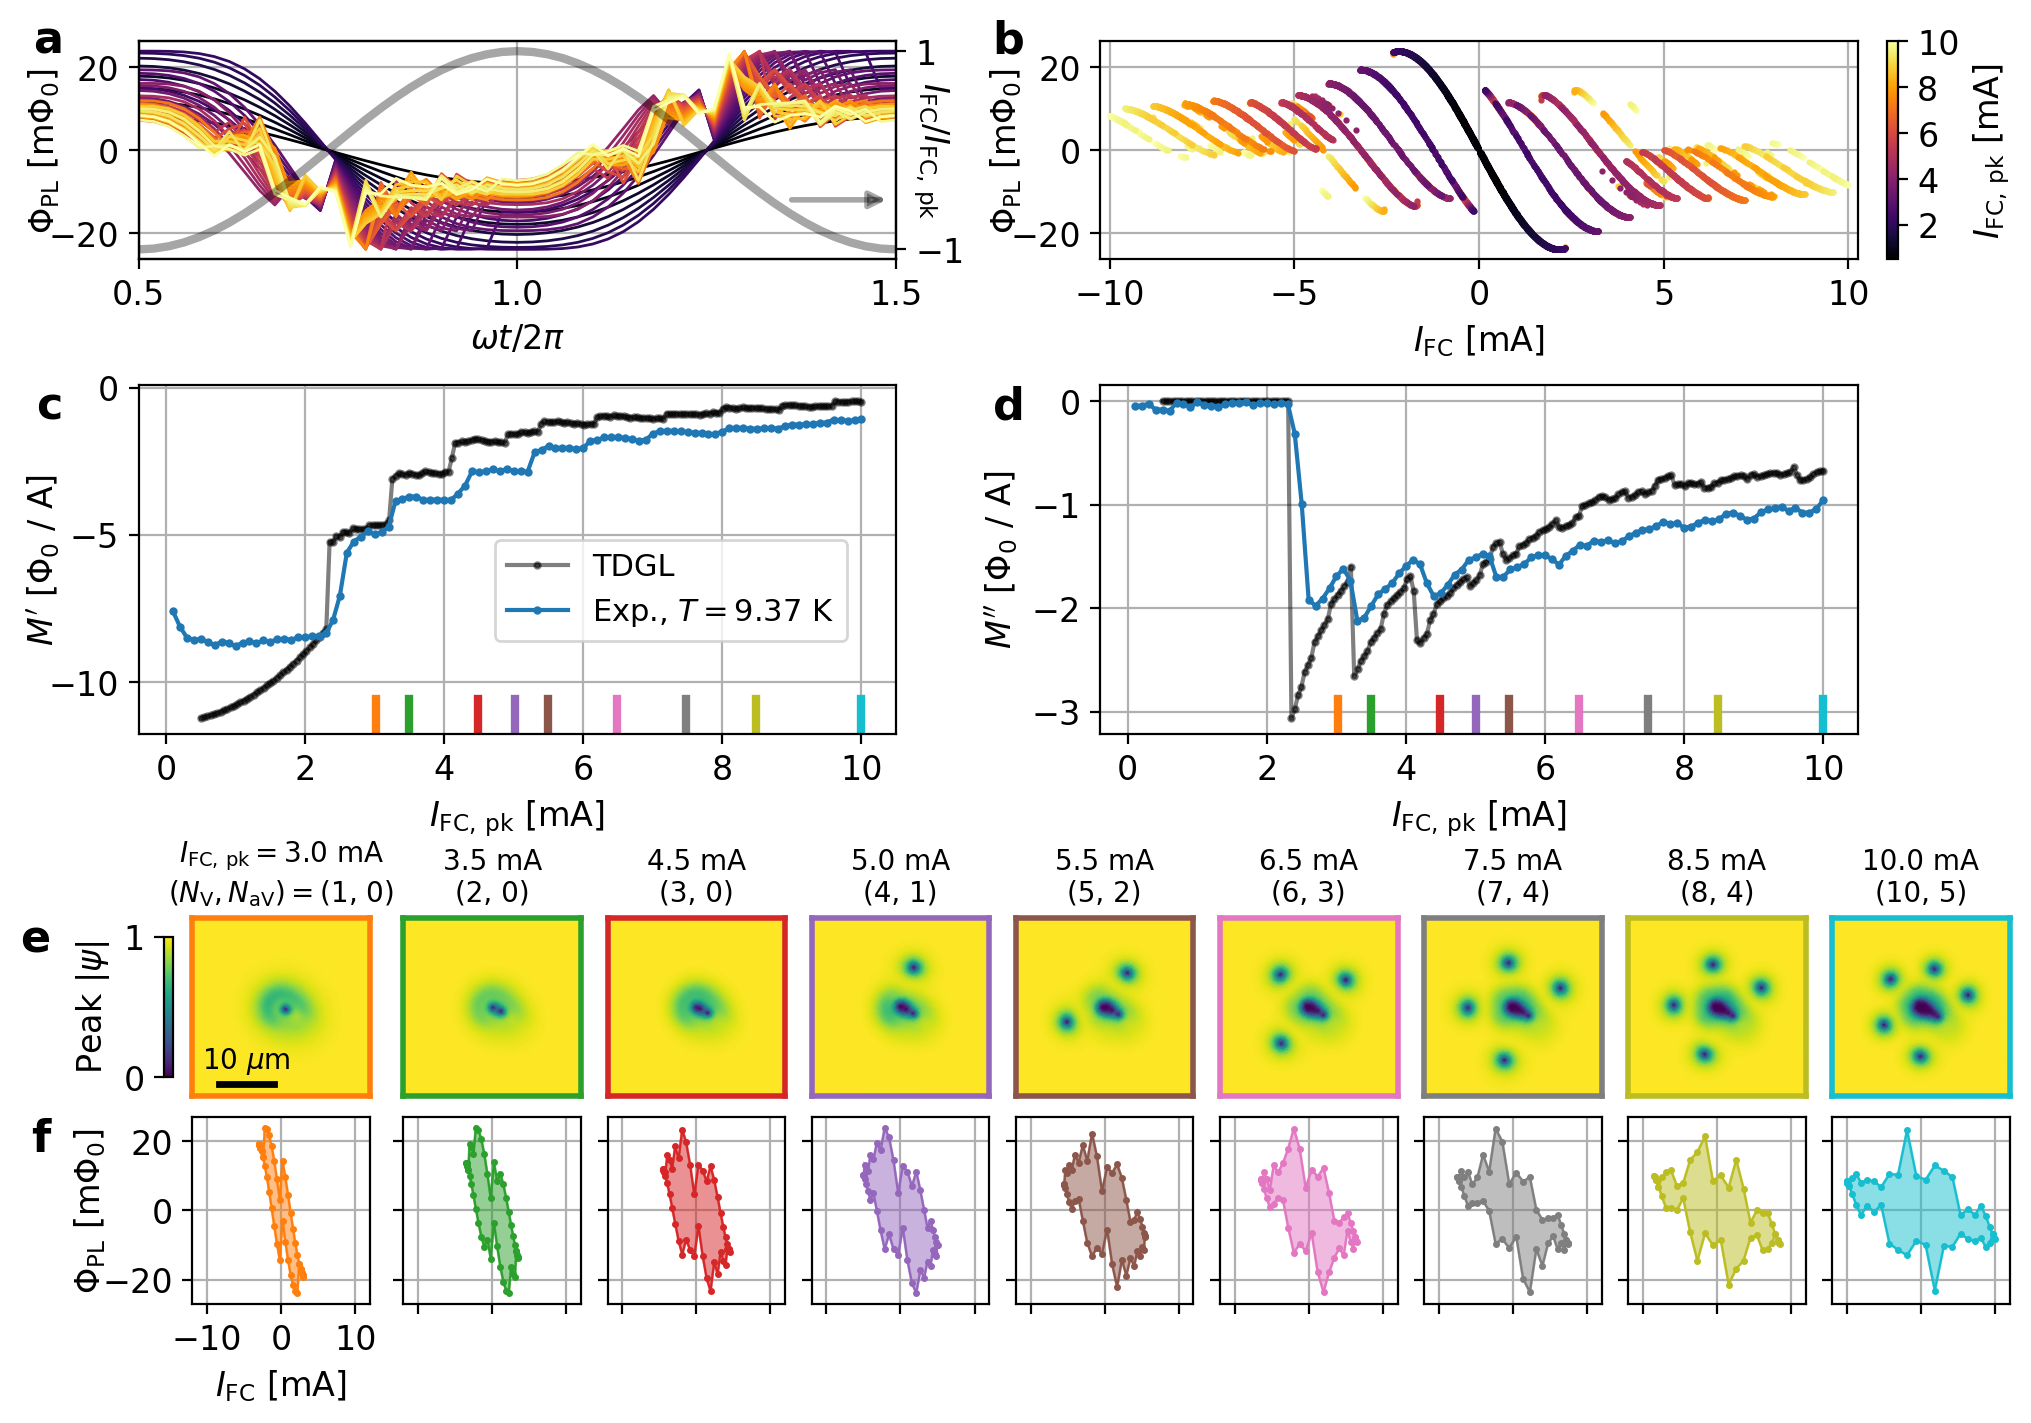

In [13]:
plt.rcParams["font.size"] = 12

fig = plt.figure(figsize=(10, 7), constrained_layout=True)

gs = fig.add_gridspec(3, 2, height_ratios=[1.25, 2, 3.25])
ncols = gs.ncols
ax = fig.add_subplot(gs[0, :ncols//2])
bx = fig.add_subplot(gs[0, ncols//2:])
cx = fig.add_subplot(gs[1, :ncols//2])
dx = fig.add_subplot(gs[1, ncols//2:])

ncols_psi = 9
gs2 = gs[-1, :].subgridspec(2, ncols_psi, height_ratios=[1, 1])
axes = [fig.add_subplot(gs2[0, j]) for j in range(ncols_psi)]
bxes = [fig.add_subplot(gs2[1, j]) for j in range(ncols_psi)]
for a in axes:
    a.set_aspect("equal")
    a.set_xticks([])
    a.set_yticks([])

susc = []
all_fluxoids = []
all_currents = {}
all_fluxes = {}
all_areas = []
ts = None

cmap = "inferno"

colors = plt.get_cmap(cmap)(np.linspace(0, 1, len(paths)))

ix = slice(int(pts_per_cycle * 0.5), None)
indices = []

ax2 = ax.twinx()
ax2.set_yticks([-1, 1])
ax2.set_ylabel("$I_\\mathrm{FC}/I_{\\mathrm{FC},\\,\\mathrm{pk}}$", rotation=-90, labelpad=-5)

for i, path in enumerate(paths):
    with open(path, "r") as f:
        try:
            result = json.load(f)
        except:
            print(path)
            continue
    indices.append(i)
    index = result["args"]["index"]
    I_fc = I_fcs[index]
    current = I_fc * phase.real
    all_currents[I_fc] = current
    flux = np.array(result["flux"])
    fluxoid = np.array(result["film_fluxoid"])
    all_fluxes[I_fc] = flux
    all_fluxoids.append(fluxoid[ix])
    if ts is None:
        ts = cycles[ix]
        ax2.plot(ts, phase[ix].real, "k-", lw=3, alpha=0.35)
    susc.append(np.sqrt(2) * np.trapz(phase[ix] * flux[ix]) / (1e-3 * I_fc) / len(flux[ix]))
    if i % 5 == 0:
        ax.plot(ts, 1e3 * flux[ix], "-", color=colors[i], lw=1, alpha=1)
    bx.plot(
        current[ix], 1e3 * flux[ix],
        ".", label=str(I_fc), color=colors[i],
        alpha=1, markersize=2.5, lw=1, zorder=1000-i,
    )
    loop = geometry.polygon.Polygon(zip(current[ix], 1e3 * flux[ix]))
    all_areas.append(loop.area)
    
ax2.annotate("", (1.495, -0.5), (1.355, -0.5), arrowprops=dict(color="k", alpha=0.35, arrowstyle="-|>", linewidth=2))


susc = np.array(susc)

msize = 4
cx.plot(I_fcs, susc.real, "k.-", label="TDGL", alpha=0.5, markersize=msize)
dx.plot(I_fcs, susc.imag, "k.-", label="TDGL", alpha=0.5, markersize=msize)

mat = data[9.37]
I_fc = mat["FC_amp"]
Mx = mat["M_x"]
My = mat["M_y_vec"]
M = Mx + 1j * My
M = M * np.exp(-1j * angle) - M0
cx.plot(I_fc, M.real, "C0.-", label="Exp., $T=9.37$ K", markersize=msize)
dx.plot(I_fc, M.imag, "C0.-", label="Exp., $T=9.37$ K", markersize=msize)

cx.grid(True)
dx.grid(True)
cx.set_xlabel("$I_{\\mathrm{FC},\\,\\mathrm{pk}}$ [mA]")
dx.set_xlabel("$I_{\\mathrm{FC},\\,\\mathrm{pk}}$ [mA]")
cx.set_ylabel("$M'$ [$\\Phi_0$ / A]", labelpad=-5)
dx.set_ylabel("$M''$ [$\\Phi_0$ / A]")

dx.sharex(cx)

cx.legend(loc="upper left", bbox_to_anchor=(0.45, 0.6), fontsize=11)
cx.set_xticks(range(0, 11, 2))
cx.set_yticks([-10, -5, 0])

ax.set_ylabel("$\\Phi_\\mathrm{PL}$ [m$\\Phi_0$]", labelpad=-5)
ax.grid(True)    
bx.grid(True)
ax.set_xticks([0.5, 1, 1.5])
ax.set_xlim(0.5, 1.5)
bx.set_xlim(-10.25, 10.25)
ax.set_xlabel("$\\omega t/2\\pi$")
bx.set_xlabel("$I_\\mathrm{FC}$ [mA]")
bx.set_ylabel("$\\Phi_\\mathrm{PL}$ [m$\\Phi_0$]", labelpad=-5)


sm = plt.cm.ScalarMappable(cmap=cmap, norm=plt.Normalize(vmin=I_fcs[0], vmax=I_fcs[-1]))
cbar = fig.colorbar(sm, ax=[ax, bx], aspect=20, pad=0.01)
for i in highlight_indices:
    curr = I_fcs[i]
    color = "w" if curr < 10 else "k"
cbar.set_ticks(range(2, 11, 2))
    
cbar.set_label("$I_{\\mathrm{FC},\\,\\mathrm{pk}}$ [mA]")

highlight_currents = [3, 3.5, 4.5, 5, 5.5, 6.5, 7.5, 8.5, 10]
NaVs = [0, 0, 0, 1, 2, 3, 4, 4, 5]

fluxoids = []

for i, (a, b, current, NaV) in enumerate(zip(axes, bxes, highlight_currents, NaVs)):
    
    index = np.argmin(np.abs(I_fcs - current))
    current = I_fcs[index]
    color = f"C{i + 1}"
    patch  = mpl.patches.PathPatch(
        mpl.path.Path(list(zip(all_currents[current][ix], 1e3 * all_fluxes[current][ix]))),
        color=color,
        alpha=0.5,
        zorder=10,
    )
    b.add_artist(patch)
    b.plot(
        all_currents[current][ix],
        1e3 * all_fluxes[current][ix],
        ".-",
        color=color, alpha=1, lw=0.75, markersize=3
    )
    with h5py.File(os.path.join(data_dir, f"{index}/steady-state.h5"), "r") as h5file:
        tdgl_data = tdgl.solution.data.TDGLData.from_hdf5(h5file, 75)
        device = tdgl.Device.from_hdf5(h5file["solution/device"])
        mesh = device.mesh
        metadata = dict(h5file.attrs)
        
    with open(os.path.join(data_dir, f"{index}/results.json"), "r") as f:
        results = json.load(f)
        
    N = np.max(results["film_fluxoid"][ix])
    N_plus = N + NaV
    N_minus = NaV
    fluxoids.append(results["film_fluxoid"])
    
    xi = metadata["xi"]
    x = mesh.x * xi
    y = mesh.y * xi
    tri = mesh.elements
    psi = tdgl_data.psi
    im = a.tripcolor(x, y, tri, np.abs(psi), cmap="viridis", shading="gouraud", vmin=0, vmax=1)
    a.set_xlim(-15, 15)
    a.set_ylim(-15, 15)
    label = f"({N_plus:.0f}, {N_minus:.0f})"
    if i == 0:
        label = "$(N_\\mathrm{V}, N_\\mathrm{aV})=$" + label    
    
    lw = 2
    cx.axvline(current, color=color, ymax=0.1, lw=lw + 1)
    dx.axvline(current, color=color, ymax=0.1, lw=lw + 1)
    for spine in a.spines.values():
        spine.set_color(color)
        spine.set_linewidth(lw)
        
    title = f"{current:.1f} mA"
    if i == 0:
        title = "$I_{\\mathrm{FC},\\,\\mathrm{pk}} = $" + title
    a.set_title("\n".join([title, label]), fontsize=10)
    
cbar = fig.colorbar(im, ax=axes, shrink=0.75, aspect=15, location="left", pad=-0.075)
cbar.set_ticks([0, 1])
cbar.set_label("Peak $|\\psi|$")

for i, b in enumerate(bxes):
    b.set_xlim(-12, 12)
    b.set_ylim(-27, 27)
    b.grid(True)
    b.set_yticks([-20, 0, 20])
    if i == 0:
        b.set_xlabel("$I_\\mathrm{FC}$ [mA]")
        b.set_ylabel("$\\Phi_\\mathrm{PL}$ [m$\\Phi_0$]", labelpad=-2)
    else:
        b.set_xticklabels([])
        b.set_yticklabels([])



for a, letter, x0, y0 in zip(
    [ax, bx, cx, dx, axes[0], bxes[0]],
    "abcdef",
    [-0.1, -0.1, -0.1, -0.1, -0.8, -0.8],
    [1.1, 1.1, 1.0, 1.0, 1, 1]
):
    a.text(x0, y0, letter, weight="bold", ha="right", va="top", size=16, transform=a.transAxes)
    

scalebar = AnchoredSizeBar(
    axes[0].transData,
    10, "10 $\\mu$m",
    "lower left",
    frameon=False,
    color="k",
    label_top=True,
    size_vertical=0.75,
    pad=0.25,
    fontproperties=fm.FontProperties(size=10)
)
axes[0].add_artist(scalebar)

if figure_dir is not None:
    fig.set_facecolor("white")
    fig.savefig(os.path.join(figure_dir, "tdgl-sim-1.pdf"), bbox_inches="tight")